# Disaster Tweets with LSTM and GRU: Introduction to Deep Learning Week 4

## Introduction

Natural disasters can cause significant human and economic losses. Detecting these events early is crucial in mitigating their devastating consequences. One promising approach is analyzing tweets on Twitter. Social media platforms, such as Twitter, offer several advantages for disaster detection, including the ability to quickly gather large amounts of data, global reach, and capturing spontaneous reactions from users. Twitter is particularly valuable for disaster detection, as it provides timely information about the scale and severity of events, surpassing traditional methods. By leveraging Twitter data for disaster detection, emergency responders can respond more quickly and effectively, thereby reducing the impacts of disasters.

This notebook focuses on differentiating between regular random tweets and those related to natural disasters. The main objective is to practice natural language processing techniques, including text data preprocessing, exploratory data analysis, and model evaluation.

## Dataset Description

The dataset for this project consists of three files: train.csv, test.csv, and sample_submission.csv. The train.csv file contains the training set, which includes samples of tweets along with additional information. Each sample in the train and test sets follows a specific format. It includes the text of a tweet, which provides the main content of the message. Additionally, each tweet may have an associated keyword, although this field can be blank. The dataset also includes the location from which the tweet was sent, which may also be blank for some tweets.

The objective of this project is to predict whether a given tweet is about a real disaster or not. To make predictions, a binary classification task is performed. If a tweet is about a real disaster, the target value is 1, and if it is not, the target value is 0.

The dataset files are organized as follows: train.csv contains the training samples, test.csv contains the test samples, and sample_submission.csv provides a sample submission file in the correct format for submitting predictions. Each tweet in the dataset is uniquely identified by an "id" column. The "text" column contains the actual text of the tweet, while the "location" column indicates the location from which the tweet was sent. Both the "location" and "keyword" columns may contain blank values. In the train.csv file, an additional "target" column denotes whether a tweet is about a real disaster (1) or not (0).

By analyzing the provided dataset and training a predictive model, we aim to accurately classify tweets and identify those that relate to real disasters, enabling effective disaster detection and response.

<a id="Importing_the_necessary_packages_and_files"></a>

# Importing the necessary packages and files

In [31]:
import numpy as np
import pandas as pd
import os

# Data processing
import re
import string
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Modeling
import torch
import copy
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import optuna
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

# Set fixed random seed for coherent results
import random

seed_val = 3
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [32]:
#import the datasets
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test= pd.read_csv("../input/nlp-getting-started/test.csv")

In [33]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [35]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [36]:
text=train['text']
label=train['target']

<a id="Text_data_preprocessing"></a>

# Text data preprocessing

The `clean_text` function performs essential preprocessing steps to improve the accuracy of models using text data. It involves several operations such as expanding contractions, removing HTML tags, eliminating email addresses and emojis, replacing specific terms or acronyms, removing URLs, filtering out words with numbers, removing punctuation, eliminating stop words, and normalizing the text by converting it to lowercase and removing extra spaces.

These preprocessing steps are necessary to increase the accuracy of models because they help in standardizing the text and removing irrelevant or noisy elements. By expanding contractions, the function ensures consistency in the representation of words. Removing HTML tags is crucial to focus on the textual content of the tweets and avoid including irrelevant markup. Eliminating email addresses and emojis helps to maintain the text's integrity and remove potentially distracting information. Replacing specific terms or acronyms with their expanded forms helps in standardizing the text and avoiding the inclusion of domain-specific jargon. Removing URLs is important to eliminate web addresses that may not contribute to the analysis. Filtering out words with numbers, punctuation, and stop words reduces noise and allows models to focus on more meaningful words.

In [37]:
def clean_text(text):
    
    # Expanding chatwords and contracts clearing contractions
    mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }
    
    
    
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])     #apply mapping to the tweets
    
    text = BeautifulSoup(text).get_text()    #remove HTML tags
    
    text=re.sub('[\w\.-]+@[\w\.-]+\.\w+', ' ', text)    #remove emails
    
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    
    text = re.sub(r"mh370", "missing malaysia airlines flight", text) #the next rows are used to expand common achronims
    text = re.sub(r"okwx", "oklahoma city weather", text)
    text = re.sub(r"arwx", "arkansas weather", text)    
    text = re.sub(r"gawx", "georgia weather", text)  
    text = re.sub(r"scwx", "south carolina weather", text)  
    text = re.sub(r"cawx", "california weather", text)
    text = re.sub(r"tnwx", "tennessee weather", text)
    text = re.sub(r"azwx", "arizona weather", text)  
    text = re.sub(r"alwx", "alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)    
    text = re.sub(r"usnwsgov", "united states national weather service", text)
    text = re.sub(r"suruc", "sanliurfa", text)
    
    text = re.sub(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', '', text)     # Remove urls
    
    text = re.sub('\w*\d\w*', '', text)     # Remove words with numbers
    
    text = "".join([word.lower() for word in text if word not in string.punctuation]) # Remove punctuation
    
    stop_words = set(stopwords.words('english')) 
    text=' '.join([word for word in text.split() if word.isalpha() and word not in stop_words])   # Remove stopwords
    
    text = re.sub(' +', ' ', text).strip()            #removes extra spaces
    
    return text

In [38]:
#example of cleaning text

clean_text("    Check these out: http://t.co/rOI2NSmEJJ, #hurricane")

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


'check hurricane'

In [39]:
#applying the cleaning to the texts

text=text.apply(clean_text)
text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                   utc volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

<a id="Exploratory_Data_Analysis_and_Visualization"></a>

# Exploratory Data Analysis and Visualization

In [40]:
df = pd.DataFrame()
df['text']=text
df['label']=label
df.shape

(7613, 2)

In [41]:
#no data is null
df.isnull().sum()

text     0
label    0
dtype: int64

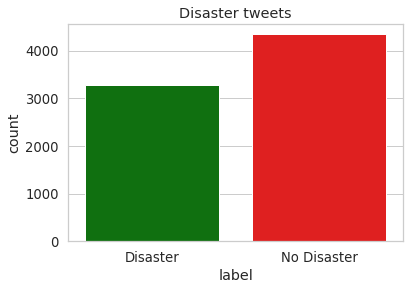

In [42]:
#Number of tweets regarding disasters compared to the ones not regarding disasters
sns.set(style="whitegrid", font_scale=1.2)
sns.countplot(x=df.label, palette=['green','red'], order=[1, 0])
plt.xticks(ticks=np.arange(2), labels=['Disaster','No Disaster'])
plt.title('Disaster tweets')
plt.show()

The distribution of data in this dataset shows a nearly symmetrical balance between disaster and non-disaster instances. This balanced distribution alleviates concerns regarding biased data.

In [43]:
df.head(10)

,text,label
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1
5,rockyfire update california hwy closed directi...,1
6,flood disaster heavy rain causes flash floodin...,1
7,top hill see fire woods,1
8,theres emergency evacuation happening building...,1
9,afraid tornado coming area,1


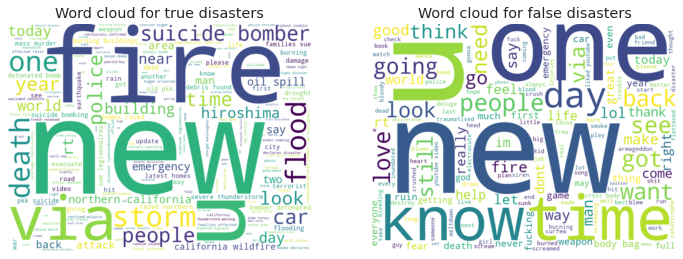

In [44]:
# Word clouds for true and false disasters
positive_data = df[df.label == 1]['text']
positive_data_string = ' '.join(positive_data)
wcp = WordCloud(max_words=200, width=800, height=600, background_color="white").generate(positive_data_string)

negative_data = df[df.label == 0]['text']
negative_data_string = ' '.join(negative_data)
wcn = WordCloud(max_words=150, width=800, height=600, background_color="white").generate(negative_data_string)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

axs[0].imshow(wcp, interpolation='bilinear')
axs[0].set_title('Word cloud for true disasters')
axs[0].axis('off')

axs[1].imshow(wcn, interpolation='bilinear')
axs[1].set_title('Word cloud for false disasters')
axs[1].axis('off')

plt.show()

<AxesSubplot:xlabel='len', ylabel='Count'>

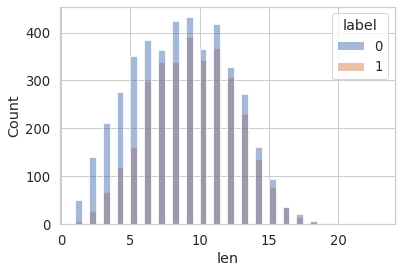

In [45]:
#difference in length between disaster reviews and not

df['len']=df['text'].str.split().map(lambda x: len(x))

sns.histplot(data=df, x='len', hue="label")


<a id="Preparing_Data_for_the_models"></a>

# Preparing Data for the models

In [46]:
# Splitting into train and validation
validation_size = 0.15

train, val = train_test_split(df, test_size=validation_size)

In [47]:
# Defining Vocabulary
maxlen = train['text'].str.split().apply(len).max()

word_counts = train['text'].str.split().explode().value_counts()
vocab = {"PAD": 0, "UNK": 1}

for word in word_counts.index:
    if word not in vocab:  # word has not been assigned an index yet
        vocab[word] = len(vocab)  # Assign each word with a unique index

print(maxlen, len(vocab))


23 14616


In [48]:
#One hot encoding for both the train and the validation dataset

def prepare_sequence(text, vocab, maxlen):
    idxs = [vocab[w] if w in vocab else vocab["UNK"] for w in text.split()]
    idxs = [idxs[i] if i < len(idxs) else vocab["PAD"] for i in range(maxlen)]

    return torch.tensor(idxs, dtype=torch.long)

class TweetDisasterDataset(Dataset):
    
    def __init__(self, df, vocab, maxlen):
        super(TweetDisasterDataset, self).__init__()
        
        self.text = df.text.apply(prepare_sequence, args=(vocab, maxlen)).tolist()
        self.label = df.label.tolist()


    def __getitem__(self, index):
        return self.text[index], self.label[index]

    def __len__(self):
        return len(self.label)

    def get_sentiment(self):
        return self.label
    
trainset = TweetDisasterDataset(train, vocab, maxlen)
valset = TweetDisasterDataset(val, vocab, maxlen)

In this step, one-hot encoding is applied to both the training and validation datasets for the task of classifying tweets as either related to a disaster or not. The prepare_sequence function is used to convert each tweet's text into a sequence of indices based on a provided vocabulary. Words in the text are mapped to their respective indices, with unknown words represented as a special "UNK" index. The sequence is then padded or truncated to a fixed length, maxlen, to ensure consistency in input size.

The TweetDisasterDataset class is implemented as a PyTorch Dataset, serving as a container for the tweet texts and corresponding labels. During initialization, the text is transformed using prepare_sequence and stored as a list, while the labels are extracted from the original dataset. The class provides methods to retrieve individual items and the dataset length.

<a id="Modeling_LSTM"></a>

# Modeling - LSTM

The LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) that is particularly well-suited for sequential data analysis. In this project, the LSTM model is chosen as it can effectively capture the temporal dependencies and contextual information present in text data, such as tweets.

The LSTM model is designed to address the vanishing gradient problem in traditional RNNs, allowing it to retain and propagate information over long sequences. It achieves this through its memory cells, which store and update information over time, enabling the model to capture long-term dependencies in the text.

The nature of tweets, with their limited character count and inherent brevity, makes the LSTM model a suitable choice. It can learn patterns and relationships within short text sequences, helping to discern whether a tweet is related to a real disaster or not. Additionally, the LSTM model's ability to handle variable-length sequences makes it adaptable to tweets of different lengths.

In [49]:
class GeneralModel(nn.Module):
    
    def train_classifier(self, trainloader, valloader, epochs, criterion, optimizer, device, tune=False):
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        best_epoch = 0
        best_loss = np.Inf
        best_acc = 0
        
        for ep in (range(epochs) if not tune else tqdm(range(epochs))):
            self.train()
            running_loss = 0.0
            acc = 0
            total = 0

            for it, (revs, labels) in enumerate(tqdm(trainloader) if not tune else trainloader):
                revs = revs.to(device)
                labels = labels.to(device)

                # Forward pass
                logits = self.forward(revs)
                loss = criterion(logits.squeeze(-1), labels.float())
                
                optimizer.zero_grad()
                
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()

                # Accuracy
                predictions = torch.round(torch.sigmoid(logits)).detach().cpu().numpy()
                predictions = [int(p) for p in predictions]
                acc += (predictions == labels.detach().cpu().numpy()).sum()
                total += len(labels)
            
            train_loss = running_loss/len(trainloader)
            if not tune:
                train_losses.append(train_loss)

            epoch_acc = acc * 100 / total
            if not tune:
                train_accs.append(epoch_acc)

            # Validation
            val_loss, val_acc = self.validation(valloader, criterion, device, tune)

            if not tune:
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                
                print(f"\nEpoch {ep + 1}")
                print(f"\tTrain Loss {round(train_loss, 3)} - Train Accuracy {round(epoch_acc, 2)}%")
                print(f"\tValid Loss {round(val_loss, 3)} - Valid Accuracy {round(val_acc, 2)}%\n")
            
            if val_loss < best_loss:
                if not tune:
                    print(f"\tBest validation loss improved from {round(best_loss, 3)} to {round(val_loss, 3)}\n")
                best_loss = val_loss
            
            if val_acc > best_acc:
                if not tune:
                    print(f"\tBest accuracy improved from {round(best_acc, 3)} to {round(val_acc, 3)}\n")
                best_acc = val_acc
        
        return train_losses, val_losses, train_accs, val_accs, best_loss, best_acc


    def validation(self, dataloader, criterion, device, tune):
        self.eval()

        running_loss = 0
        acc = 0
        total = 0

        for it, (revs, labels) in enumerate(tqdm(dataloader) if not tune else dataloader):
            with torch.no_grad():
                revs = revs.to(device)
                labels = labels.to(device)
                
                logits = self.forward(revs)
                
                loss = criterion(logits.squeeze(-1), labels.float())
                running_loss += loss.item()

                predictions = torch.round(torch.sigmoid(logits)).detach().cpu().numpy()
                predictions = [int(p) for p in predictions]
                acc += (predictions == labels.detach().cpu().numpy()).sum()

                total += len(labels)

        val_loss = running_loss / len(dataloader)
        val_acc = acc * 100 / total

        return val_loss, val_acc


In [50]:
#defining LSTM Model, one layer for an Embedding, one for the LSTM, one for the classification

class LSTMModel(GeneralModel):
    
    def __init__(self, maxlen, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        L = maxlen          
        D = 2               
        Hout = hidden_dim   

        # The Classification Linear layer.
        self.cls = nn.Linear(L * D * Hout, 1)
        

    def forward(self, idxs):

        embeds = self.word_embeddings(idxs)
        lstm_out, _ = self.lstm(embeds)

        return self.cls(lstm_out.view(len(idxs), -1))

<a id="Modeling_LSTM_HT"></a>

## Hyperparameter tuning for LSTM Model

In this section, hyperparameter tuning is conducted using the Optuna library to optimize the performance of the LSTM model. The `objective` function is defined, which samples various hyperparameters such as learning rate, weight decay, optimizer type, embedding dimension, hidden dimension, and batch size. The model is built with the sampled hyperparameters, and the training process is executed using the created LSTM model, along with appropriate data loaders and criterion. The goal is to maximize the accuracy of the model in predicting whether a tweet corresponds to a real disaster or not. The Optuna study object is then created, and the `study.optimize` method is called to perform the hyperparameter optimization. By running multiple trials, Optuna explores different combinations of hyperparameters, aiming to find the configuration that yields the highest accuracy. Through this iterative process, the LSTM model can be fine-tuned to achieve better predictive performance.

In [51]:
def build_LSTMmodel(config, maxlen, vocab_size,):
    return LSTMModel(maxlen, vocab_size, config['EMB_DIM'],config['HID_DIM'])

#tuning the different parameters with Optuna
def objective(trial):

    config = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 5e-4, 1e-2),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-2),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
              'EMB_DIM': trial.suggest_int("EMB_DIM", 10, 100),
              'HID_DIM': trial.suggest_int("HID_DIM", 10, 100),
              "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
              }
    
    model = build_LSTMmodel(config, maxlen, len(vocab))
                        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'],weight_decay= config['weight_decay'])
    criterion = nn.BCEWithLogitsLoss().to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'])
    valloader = torch.utils.data.DataLoader(valset, batch_size=config['batch_size'])
    
    epochs = 8
    
    _,_,_,_,best_loss,best_acc= model.train_classifier(trainloader, valloader, epochs, criterion, optimizer, device, True)

    return best_acc

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

study.optimize(objective, n_trials=30)

[I 2023-07-13 04:34:45,366] A new study created in memory with name: no-name-f298fe8f-4aba-4667-956d-08239bb07743
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
100%|██████████| 8/8 [00:12<00:00,  1.57s/it]
[I 2023-07-13 04:34:57,987] Trial 0 finished with value: 77.49562171628722 and parameters: {'learning_rate': 0.003111037666827463, 'weight_decay': 2.915103060901672e-05, 'optimizer': 'Adam', 'EMB_DIM': 49, 'HID_DIM': 61, 'batch_size': 16}. Best

In [52]:
#show the best configuration for the hyperparameters
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))
    

learning_rate: 0.009420492953152396
weight_decay: 1.0913119950933079e-05
optimizer: Adam
EMB_DIM: 41
HID_DIM: 52
batch_size: 16


After conducting hyperparameter tuning using Optuna, the best configuration for the hyperparameters was determined. The optimal values are as follows: learning rate of 0.009420492953152396, weight decay of 1.0913119950933079e-05, optimizer type of Adam, embedding dimension of 41, hidden dimension of 52, and a batch size of 16. These values were identified as the ones that maximize the accuracy of the LSTM model in predicting whether a tweet is related to a real disaster. By fine-tuning the hyperparameters, the model's performance can be significantly improved, leading to more accurate and reliable predictions.

<a id="LSTM_results"></a>
## LSTM - Best results

In [53]:
#build the model with the best hyperparameters
config = best_trial.params
    
model = build_LSTMmodel(config, maxlen, len(vocab))
                        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'],weight_decay= config['weight_decay'])
criterion = nn.BCEWithLogitsLoss().to(device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'])
valloader = torch.utils.data.DataLoader(valset, batch_size=config['batch_size'])
    
epochs = 8
    
train_losses, val_losses, train_accs, val_accs,_,_= model.train_classifier(trainloader, valloader, epochs, criterion, optimizer, device, False)

100%|██████████| 72/72 [00:00<00:00, 819.95it/s]



Epoch 1
	Train Loss 0.567 - Train Accuracy 69.93%
	Valid Loss 0.477 - Valid Accuracy 78.63%

	Best validation loss improved from inf to 0.477

	Best accuracy improved from 0 to 78.634



100%|██████████| 72/72 [00:00<00:00, 840.66it/s]



Epoch 2
	Train Loss 0.269 - Train Accuracy 89.18%
	Valid Loss 0.631 - Valid Accuracy 77.23%



100%|██████████| 72/72 [00:00<00:00, 827.04it/s]



Epoch 3
	Train Loss 0.114 - Train Accuracy 95.83%
	Valid Loss 0.827 - Valid Accuracy 77.23%



100%|██████████| 72/72 [00:00<00:00, 865.29it/s]



Epoch 4
	Train Loss 0.053 - Train Accuracy 98.13%
	Valid Loss 0.977 - Valid Accuracy 77.5%



100%|██████████| 72/72 [00:00<00:00, 830.41it/s]



Epoch 5
	Train Loss 0.043 - Train Accuracy 98.84%
	Valid Loss 0.955 - Valid Accuracy 77.15%



100%|██████████| 72/72 [00:00<00:00, 835.35it/s]



Epoch 6
	Train Loss 0.027 - Train Accuracy 99.18%
	Valid Loss 1.097 - Valid Accuracy 76.97%



100%|██████████| 72/72 [00:00<00:00, 782.69it/s]



Epoch 7
	Train Loss 0.032 - Train Accuracy 98.98%
	Valid Loss 1.135 - Valid Accuracy 76.53%



100%|██████████| 72/72 [00:00<00:00, 528.66it/s]


Epoch 8
	Train Loss 0.051 - Train Accuracy 98.41%
	Valid Loss 1.241 - Valid Accuracy 76.36%



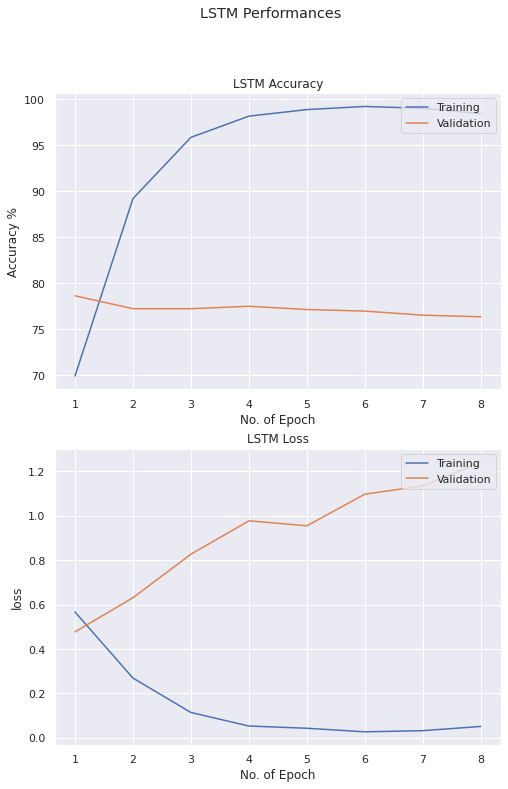

In [54]:
# plot the losses and the accuracy for the best model

sns.set()
fig, (fig1, fig2) = plt.subplots(2, figsize=(8,12))
fig1.plot(range(1, epochs+1), train_accs, label="Training")
fig1.plot(range(1, epochs+1), val_accs, label="Validation")
fig1.set(xlabel="No. of Epoch", ylabel="Accuracy %", title="LSTM Accuracy")
fig1.legend(loc="upper right")

fig2.plot(range(1, epochs+1), train_losses, label="Training")
fig2.plot(range(1, epochs+1), val_losses, label="Validation")
fig2.set(xlabel="No. of Epoch", ylabel="loss", title="LSTM Loss")
fig2.legend(loc="upper right")
fig.suptitle('LSTM Performances')
fig.show()

<a id="Modeling_GRU"></a>

# Modeling - GRU



The Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that has gained popularity in natural language processing tasks, including text classification tasks like the one in this project. GRU is well-suited for this project due to its ability to capture long-range dependencies in sequential data while mitigating the vanishing gradient problem. It achieves this by utilizing gating mechanisms that selectively update and reset information within the hidden state. This allows GRU to effectively model the context and temporal dependencies present in textual data, enabling it to capture important patterns and nuances in the tweets. Additionally, GRU has fewer parameters compared to other RNN variants like LSTM, making it computationally efficient while still providing competitive performance. Overall, the GRU architecture's ability to handle sequential data and its efficiency make it a suitable choice for text classification tasks such as identifying disaster-related tweets.

In [55]:
#defining GRU Model, one layer for an Embedding, one for the GRU, one for the classification
#I didn't do it together with the LSTM to compare the results

class GRUModel(GeneralModel):
    
    def __init__(self, maxlen, vocab_size, embedding_dim, hidden_dim):
        super(GRUModel, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, bidirectional=True)
        
        L = maxlen          
        Hout = hidden_dim  
        
        self.cls = nn.Linear(L * Hout*2, 1)

    def forward(self, idxs):

        embeds = self.word_embeddings(idxs)
        gru_out, _ = self.gru(embeds)

        return self.cls(gru_out.view(len(idxs), -1))

def build_GRUmodel(config, maxlen, vocab_size,):
    return GRUModel(maxlen, vocab_size, config['EMB_DIM'],config['HID_DIM'])

The GRU model consists of several layers, including an embedding layer, a GRU layer, and a classification layer. The embedding layer is responsible for representing words as dense vectors. The GRU layer is a type of recurrent neural network layer that processes sequential data and captures temporal dependencies. The GRU model used in this code is designed to handle bidirectional processing, allowing it to consider the context both preceding and following each word in the input sequence. The classification layer applies linear transformation to the output of the GRU layer to predict whether a given text belongs to a real disaster class or a non-disaster class. The code also includes a function to build the GRU model based on provided configuration parameters. By using the GRU architecture, this model can effectively capture sequential patterns and dependencies in the text data, making it suitable for text classification tasks such as identifying disaster-related tweet.

<a id="Modeling_GRU_HT"></a>
## Hyperparameter tuning for GRU Model

The Optuna library is used for the tuning process. The objective function is defined to take a set of hyperparameters as input and returns the best accuracy achieved by the GRU model with those hyperparameters. The hyperparameters being tuned include learning rate, weight decay, optimizer choice (Adam or SGD), embedding dimension (EMB_DIM), hidden dimension (HID_DIM), and batch size. The build_GRUmodel function is called to construct the GRU model using the hyperparameters. The model is then trained and evaluated using the training and validation datasets. The hyperparameter tuning is performed using the Optuna library's study object, which explores different combinations of hyperparameters to find the best configuration. The tuning process aims to maximize the accuracy of the GRU model by finding the optimal hyperparameter values.

In [56]:
#Hyperparameter tuning for the GRU model
def objective(trial):

    config = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 5e-4, 1e-2),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
              'EMB_DIM': trial.suggest_int("EMB_DIM", 10, 100),
              'HID_DIM': trial.suggest_int("HID_DIM", 10, 100),
              "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
              }
    
    model = build_GRUmodel(config, maxlen, len(vocab))
                        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'],weight_decay= config['weight_decay'])
    criterion = nn.BCEWithLogitsLoss().to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'])
    valloader = torch.utils.data.DataLoader(valset, batch_size=config['batch_size'])
    
    epochs = 8
    
    _,_,_,_,best_loss,best_accuracy= model.train_classifier(trainloader, valloader, epochs, criterion, optimizer, device, True)

    return best_accuracy

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

study.optimize(objective, n_trials=30)

[I 2023-07-13 04:40:14,106] A new study created in memory with name: no-name-8e253a99-3191-456d-b9ef-5e283a0fe8b4
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
[I 2023-07-13 04:40:20,302] Trial 0 finished with value: 56.47985989492119 and parameters: {'learning_rate': 0.0012194653012430753, 'weight_decay': 2.0476637660855374e-05, 'optimizer': 'SGD', 'EMB_DIM': 68, 'HID_DIM': 31, 'batch_size': 32}. Best is trial 0 with value

In [57]:
#Showing the best result for the hyperparameter tuning of the GRU
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.004949825979854808
weight_decay: 4.583535521192671e-06
optimizer: Adam
EMB_DIM: 57
HID_DIM: 58
batch_size: 16


After performing hyperparameter tuning for the GRU model, the best set of hyperparameters was identified. The optimal configuration for the GRU model includes a learning rate of 0.004949825979854808, weight decay of 4.583535521192671e-06, and Adam optimizer. The embedding dimension (EMB_DIM) is set to 57, the hidden dimension (HID_DIM) is set to 58, and the batch size is 16. These hyperparameters were determined to yield the highest accuracy for the GRU model during the tuning process. By fine-tuning the hyperparameters, the model can achieve better performance and enhance its ability to classify tweets as real disasters or not.

<a id="GRU_results"></a>
## GRU - Best results

In [58]:
#buiding the GRU model with the best parameters
config = best_trial.params
    
model = build_GRUmodel(config, maxlen, len(vocab))
                        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'],weight_decay= config['weight_decay'])
criterion = nn.BCEWithLogitsLoss().to(device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'])
valloader = torch.utils.data.DataLoader(valset, batch_size=config['batch_size'])
    
epochs = 8
    
train_losses, val_losses, train_accs, val_accs, _,_= model.train_classifier(trainloader, valloader, epochs, criterion, optimizer, device, False)

100%|██████████| 72/72 [00:00<00:00, 843.54it/s]



Epoch 1
	Train Loss 0.641 - Train Accuracy 65.32%
	Valid Loss 0.572 - Valid Accuracy 73.82%

	Best validation loss improved from inf to 0.572

	Best accuracy improved from 0 to 73.818



100%|██████████| 72/72 [00:00<00:00, 866.06it/s]



Epoch 2
	Train Loss 0.344 - Train Accuracy 85.41%
	Valid Loss 0.648 - Valid Accuracy 76.09%

	Best accuracy improved from 73.818 to 76.095



100%|██████████| 72/72 [00:00<00:00, 817.78it/s]



Epoch 3
	Train Loss 0.15 - Train Accuracy 94.19%
	Valid Loss 0.824 - Valid Accuracy 77.32%

	Best accuracy improved from 76.095 to 77.32



100%|██████████| 72/72 [00:00<00:00, 794.92it/s]



Epoch 4
	Train Loss 0.065 - Train Accuracy 97.59%
	Valid Loss 0.988 - Valid Accuracy 76.09%



100%|██████████| 72/72 [00:00<00:00, 858.76it/s]



Epoch 5
	Train Loss 0.026 - Train Accuracy 99.21%
	Valid Loss 1.063 - Valid Accuracy 75.92%



100%|██████████| 72/72 [00:00<00:00, 842.18it/s]



Epoch 6
	Train Loss 0.011 - Train Accuracy 99.71%
	Valid Loss 1.164 - Valid Accuracy 77.85%

	Best accuracy improved from 77.32 to 77.846



100%|██████████| 72/72 [00:00<00:00, 509.41it/s]



Epoch 7
	Train Loss 0.004 - Train Accuracy 99.86%
	Valid Loss 1.183 - Valid Accuracy 77.06%



100%|██████████| 72/72 [00:00<00:00, 833.91it/s]


Epoch 8
	Train Loss 0.002 - Train Accuracy 99.95%
	Valid Loss 1.384 - Valid Accuracy 77.32%



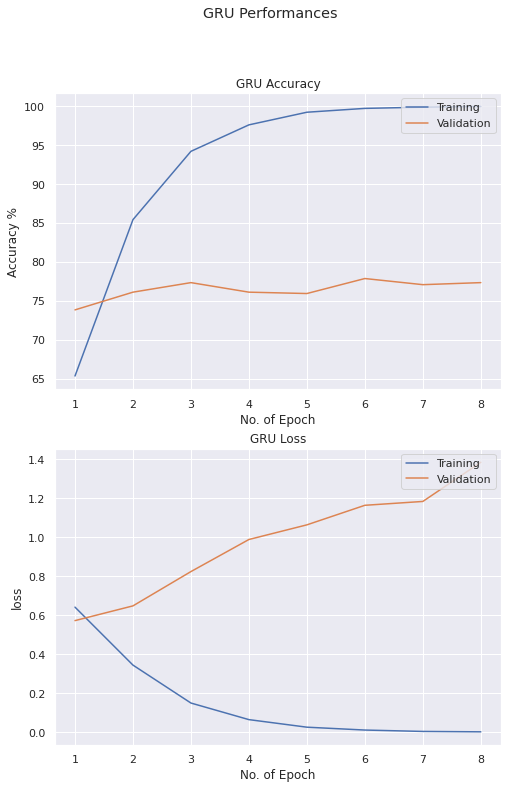

In [59]:
#Plotting accuracies and losses for the best GRU model
sns.set()
fig, (fig1, fig2) = plt.subplots(2, figsize=(8,12))
fig1.plot(range(1, epochs+1), train_accs, label="Training")
fig1.plot(range(1, epochs+1), val_accs, label="Validation")
fig1.set(xlabel="No. of Epoch", ylabel="Accuracy %", title="GRU Accuracy")
fig1.legend(loc="upper right")

fig2.plot(range(1, epochs+1), train_losses, label="Training")
fig2.plot(range(1, epochs+1), val_losses, label="Validation")
fig2.set(xlabel="No. of Epoch", ylabel="loss", title="GRU Loss")
fig2.legend(loc="upper right")
fig.suptitle('GRU Performances')
fig.show()

<a id="Submission"></a>
# Submitting the results 

In [60]:
# preparing the data from the test and using the model to calculate the results

textT=test['text']
textT=textT.apply(clean_text)
test_inputs, test_masks = tokenize_map(textT.values, maxlen)

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=config['batch_size'])

# Put model in evaluation mode:
model.eval()
# Tracking variables :

target = []

# Predict:

for batch in test_dataloader:
    
  
    # Unpack the inputs from our dataloader:
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

    with torch.no_grad():
    # Forward pass, calculate logit predictions:
    
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU:
    logits = output[0]
    
    logits = logits.detach().cpu().numpy()
 
    # Store predictions and true labels:
    
    target.append(logits)


/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


NameError: name 'tokenize_map' is not defined

In [ ]:
predictions = [item for batch in target for item in batch]
predictions = np.argmax(predictions, axis=1).flatten()

In [ ]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submission['target'] = predictions
submission.to_csv('submission.csv', index=False, header=True)